<a href="https://colab.research.google.com/github/vmadalasa/EVAConsolidated/blob/master/S11/Madhu_final1__EVA_S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")


======================================== Memory Information ========================================
Total: 12.72GB
Available: 11.89GB
Used: 567.67MB
Percentage: 6.5%


In [ ]:
!pip install albumentations==0.4.5 --quiet

     |████████████████████████████████| 122kB 7.0MB/s 
     |████████████████████████████████| 634kB 18.2MB/s 


In [ ]:
!nvidia-smi

Fri Jun 19 06:02:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = 'cuda'
from S11_model import S11_Model

In [ ]:
model = S11_Model().to(device)

In [ ]:
from augmentation import CIFAR10_AlbumTrans
from data import CIFAR10DataLoader
from data_summary import model_summary, display

Files already downloaded and verified
Files already downloaded and verified


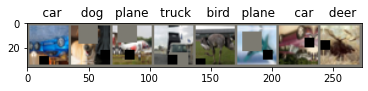

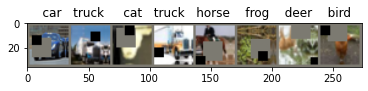

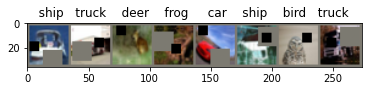

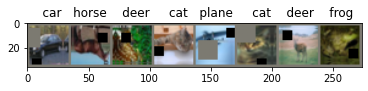

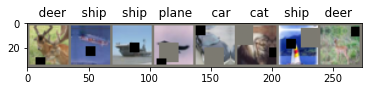

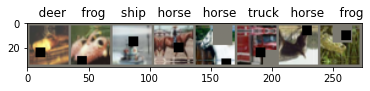

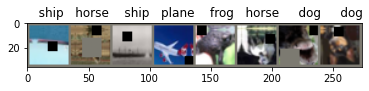

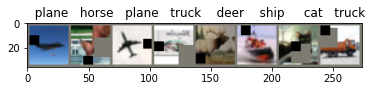

In [ ]:
trans = CIFAR10_AlbumTrans()
data = CIFAR10DataLoader(trans, batch_size=512)
train_loader, test_loader = data.get_loaders()
display(train_loader, 64)



In [ ]:
model_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
            Conv2d-7          [-1, 128, 16, 16]         147,456
       BatchNorm2d-8          [-1, 128, 16, 16]             256
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
    BasicResBlock-11          [-1, 128, 16, 16]               0
    ParallelBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-1, 25

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


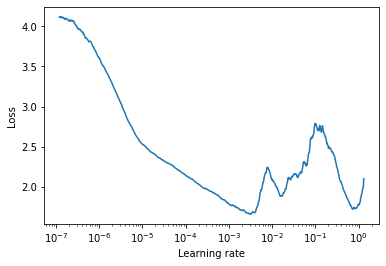

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from find_lr import LRFinder
model = S11_Model().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 1e-6, momentum= 0.9)
lr_finder = LRFinder(model, optimizer, criterion,device= 'cuda')
#lr_finder.range_test(train_loader, start_lr = 1e-7, end_lr=100, num_iter=10*len(train_loader), step_mode='exp',diverge_th=5,accumulation_steps=1) #Fast AI Approach
#lr_finder.range_test(train_loader, val_loader=test_loader, start_lr = 0.0001, end_lr=4, num_iter=500, step_mode="linear")
lr_finder.range_test(train_loader, start_lr = 1e-7, end_lr=10, num_iter=10*len(train_loader),step_mode="exp",diverge_th=5,accumulation_steps=1) #, step_mode="linear" #new
# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

In [ ]:
print('Least Lost  ', min(lr_finder.history['loss']))
best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]
print('Best lr : ', best_lr)

Least Lost   1.6598676714548066
Best lr :  0.0031809264409701473


In [ ]:
import torch
import torch.nn as nn
from test import Test
from train import Train
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR #ReduceLROnPlateau
model = S11_Model().to(device)


#optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum= 0.9)
#test = Test(model, device, test_loader)
#train = Train(model, device, train_loader, optimizer)
#scheduler = ReduceLROnPlateau(optimizer, mode= 'max', patience= 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.95, nesterov=True, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                 max_lr=0.003,
                 total_steps=24,
                 steps_per_epoch=len(train_loader),
                 epochs=25,
                 pct_start=0.2,
                 cycle_momentum=True,
                 base_momentum=0.85,
                 max_momentum=0.95,
                 div_factor=100.,
                 final_div_factor=100,
                 anneal_strategy ='cos',
                 last_epoch=-1)


test = Test(model, device, test_loader)
train = Train(model, device, train_loader, optimizer)

In [ ]:
lr_list = []
epochs = 24
print('='*20 + 'START' + '='*20)
for epoch in range(epochs):
  print("EPOCH:", epoch)
  #print(lr_list)
  train.train(epoch)
  lr_list.append(optimizer.param_groups[0]['lr'])
  test.test()
  scheduler.step() 
  #test.test()


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.2151366472244263 Batch_id=97 Accuracy=48.42: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4028, Accuracy: 5972/10000 (59.72%)

EPOCH: 1


Loss=0.9685332775115967 Batch_id=97 Accuracy=58.32: 100%|██████████| 98/98 [00:28<00:00,  3.42it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3755, Accuracy: 6245/10000 (62.45%)

EPOCH: 2


Loss=1.192735195159912 Batch_id=97 Accuracy=48.13: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3919, Accuracy: 6081/10000 (60.81%)

EPOCH: 3


Loss=1.0793477296829224 Batch_id=97 Accuracy=60.75: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3036, Accuracy: 6964/10000 (69.64%)

EPOCH: 4


Loss=0.5978615880012512 Batch_id=97 Accuracy=70.41: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2442, Accuracy: 7558/10000 (75.58%)

EPOCH: 5


Loss=0.620051383972168 Batch_id=97 Accuracy=76.17: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2146, Accuracy: 7854/10000 (78.54%)

EPOCH: 6


Loss=0.815782904624939 Batch_id=97 Accuracy=79.66: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2082, Accuracy: 7918/10000 (79.18%)

EPOCH: 7


Loss=0.6179817914962769 Batch_id=97 Accuracy=82.22: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1819, Accuracy: 8181/10000 (81.81%)

EPOCH: 8


Loss=0.47276628017425537 Batch_id=97 Accuracy=84.03: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1610, Accuracy: 8390/10000 (83.90%)

EPOCH: 9


Loss=0.5103754997253418 Batch_id=97 Accuracy=86.29: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1731, Accuracy: 8269/10000 (82.69%)

EPOCH: 10


Loss=0.409525066614151 Batch_id=97 Accuracy=87.69: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1405, Accuracy: 8595/10000 (85.95%)

EPOCH: 11


Loss=0.3612307012081146 Batch_id=97 Accuracy=88.68: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1354, Accuracy: 8646/10000 (86.46%)

EPOCH: 12


Loss=0.23045869171619415 Batch_id=97 Accuracy=90.09: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1200, Accuracy: 8800/10000 (88.00%)

EPOCH: 13


Loss=0.27238157391548157 Batch_id=97 Accuracy=91.18: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1210, Accuracy: 8790/10000 (87.90%)

EPOCH: 14


Loss=0.2467281073331833 Batch_id=97 Accuracy=92.23: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1153, Accuracy: 8847/10000 (88.47%)

EPOCH: 15


Loss=0.24563194811344147 Batch_id=97 Accuracy=92.85: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1096, Accuracy: 8904/10000 (89.04%)

EPOCH: 16


Loss=0.2512713074684143 Batch_id=97 Accuracy=93.78: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1087, Accuracy: 8913/10000 (89.13%)

EPOCH: 17


Loss=0.13968226313591003 Batch_id=97 Accuracy=94.37: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1070, Accuracy: 8930/10000 (89.30%)

EPOCH: 18


Loss=0.11784044653177261 Batch_id=97 Accuracy=94.92: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1007, Accuracy: 8993/10000 (89.93%)

EPOCH: 19


Loss=0.16320034861564636 Batch_id=97 Accuracy=95.42: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1003, Accuracy: 8997/10000 (89.97%)

EPOCH: 20


Loss=0.10909215360879898 Batch_id=97 Accuracy=95.91: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0977, Accuracy: 9023/10000 (90.23%)

EPOCH: 21


Loss=0.12008549273014069 Batch_id=97 Accuracy=96.13: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0970, Accuracy: 9030/10000 (90.30%)

EPOCH: 22


Loss=0.0815490335226059 Batch_id=97 Accuracy=96.49: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0959, Accuracy: 9041/10000 (90.41%)

EPOCH: 23


Loss=0.09854177385568619 Batch_id=97 Accuracy=96.52: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]



Test set: Average loss: 0.0950, Accuracy: 9050/10000 (90.50%)



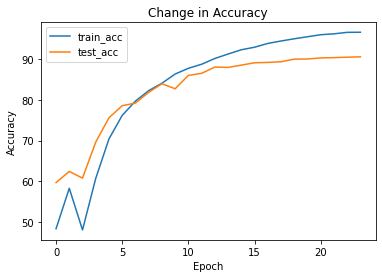

In [ ]:
from graphs import acc_loss, testvtrain, class_acc
acc_loss(train, test)
testvtrain(train, test)


In [ ]:
from evascheduler import get_misclassified
misclassified = get_misclassified()

In [ ]:
best_model = S11_Model().to(device)
best_model.load_state_dict(torch.load('/content/classifier.pt'))
best_model.eval()
#print('Best Model Loaded!')

25


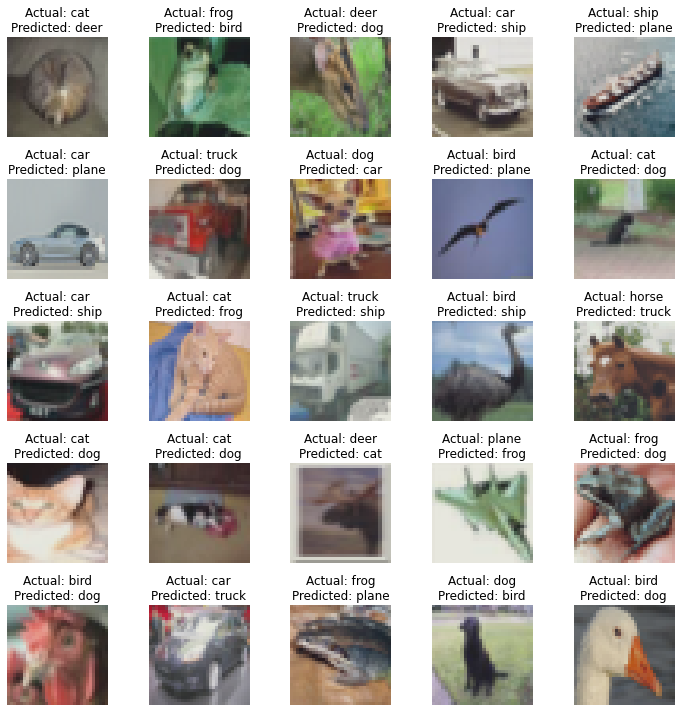

In [ ]:
import plot
from plot import mis, gen_cam, plot_pred_cam, plot_act_cam
mis(best_model, device, test_loader, 25)


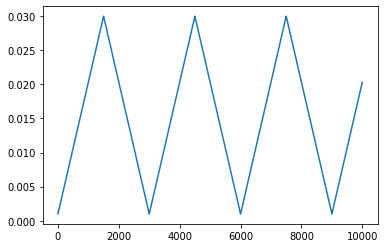

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
lr = np.zeros(7)
it = range(7)
for i in range (7):
  if(i%2==1):
    lr[i] =1;

plt.xlabel('iterations')
plt.ylabel('lr')
plt.plot(it,lr)
